# Car price prediction

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error , max_error, mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
RANDOM_SEED=42

## Preprocessing and EDA

In [2]:
df = pd.read_csv('train.csv')
df.head(3)

,Unnamed: 0,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,...,description,mileage,Комплектация,Привод,Руль,Владельцы,ПТС,Таможня,Владение,Price
0,0,Седан,AUDI,040001,бензин,1990.0,2.3 MT (133 л.с.),4.0,1991,MECHANICAL,...,\nБыстрым торг.Обмен интересен на авто с неисп...,10000,{'id': '0'},передний,LEFT,3.0,ORIGINAL,True,NaN,135000
1,1,Седан,AUDI,040001,бензин,1988.0,2.0 MT (115 л.с.),4.0,1989,MECHANICAL,...,На ходу!Очень много сделано!До аварии ездил 1....,300000,{'id': '0'},передний,LEFT,3.0,DUPLICATE,True,NaN,42000
2,2,Универсал 5 дв.,AUDI,CACECB,бензин,1990.0,2.3 MT (133 л.с.),5.0,1991,MECHANICAL,...,Новый перешитый потолок. \nМашина на полном ходу,205636,{'id': '0'},передний,LEFT,2.0,ORIGINAL,True,NaN,200000


In [3]:
df.columns

Index(['Unnamed: 0', 'bodyType', 'brand', 'color', 'fuelType', 'modelDate',
       'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'engineDisplacement', 'enginePower', 'description', 'mileage',
       'Комплектация', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'Таможня',
       'Владение', 'Price'],
      dtype='object')

In [4]:
df.iloc[2]

Unnamed: 0                                                             2
bodyType                                                 Универсал 5 дв.
brand                                                               AUDI
color                                                             CACECB
fuelType                                                          бензин
modelDate                                                           1990
name                                                   2.3 MT (133 л.с.)
numberOfDoors                                                          5
productionDate                                                      1991
vehicleConfiguration                                          MECHANICAL
engineDisplacement                                                   2.3
enginePower                                                          133
description             Новый перешитый потолок. \nМашина на полном ходу
mileage                                            

In [5]:
df.shape

(109080, 22)

In [6]:
df.isna().sum() / (df.shape[0])*100 

Unnamed: 0               0.000000
bodyType                 0.000917
brand                    0.000000
color                    0.000000
fuelType                 0.000000
modelDate                0.000917
name                     0.000917
numberOfDoors            0.000917
productionDate           0.000000
vehicleConfiguration     0.000917
engineDisplacement       0.000917
enginePower              0.000917
description              2.980381
mileage                  0.000000
Комплектация             0.000000
Привод                   0.000917
Руль                     0.000000
Владельцы                0.006417
ПТС                      0.001834
Таможня                  0.000000
Владение                63.431426
Price                    0.000000
dtype: float64

In [7]:
df.Таможня.unique()

array([ True])

In [8]:
df['Комплектация'].value_counts()[:2]

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               77978
{'id': '4562904', 'name': 'Elegance', 'available_options': ['cruise-control', 'multi-wheel', 'airbag-passenger', 'lock', 'electro-mirrors', 'mirrors-heat', 'cooling-box', 'computer', 'seat-transformation', 'wheel-power', 'fabric-seats', 'airbag-side', 'abs', 'wheel-leather', 'climate-control-1', 'esp', 'audiopreparation', 'electro-window-back', 'condition', 'music-super', 'park-assist-r', 

We have to delete some columns:
- Unnamed: 0 - we don't need the index of object
- description - in this case, we can't use RNN for NLP task
- Таможня - has only 1 value: True
- Владение - over 60% of all values - missing
- name - converted to 2 single columns: engineDisplacement and enginePower
- Комплектация - over 60% of all values are missing: {'id': '0'}

In [9]:
df.drop(['Unnamed: 0','description','Таможня','Владение','name','Комплектация'],axis=1,inplace=True)
df.dropna(inplace=True)

In [222]:
df.head(3)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Price
0,Седан,AUDI,040001,бензин,1990.0,4.0,1991,MECHANICAL,2.3,133.0,10000,передний,LEFT,3.0,ORIGINAL,135000
1,Седан,AUDI,040001,бензин,1988.0,4.0,1989,MECHANICAL,2.0,115.0,300000,передний,LEFT,3.0,DUPLICATE,42000
2,Универсал 5 дв.,AUDI,CACECB,бензин,1990.0,5.0,1991,MECHANICAL,2.3,133.0,205636,передний,LEFT,2.0,ORIGINAL,200000


In [223]:
df.isna().sum() / (df.shape[0])*100 

bodyType                0.0
brand                   0.0
color                   0.0
fuelType                0.0
modelDate               0.0
numberOfDoors           0.0
productionDate          0.0
vehicleConfiguration    0.0
engineDisplacement      0.0
enginePower             0.0
mileage                 0.0
Привод                  0.0
Руль                    0.0
Владельцы               0.0
ПТС                     0.0
Price                   0.0
dtype: float64

### Encoding

In [224]:
df.dtypes

bodyType                 object
brand                    object
color                    object
fuelType                 object
modelDate               float64
numberOfDoors           float64
productionDate            int64
vehicleConfiguration     object
engineDisplacement       object
enginePower             float64
mileage                   int64
Привод                   object
Руль                     object
Владельцы               float64
ПТС                      object
Price                     int64
dtype: object

In [225]:
df.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'engineDisplacement',
       'enginePower', 'mileage', 'Привод', 'Руль', 'Владельцы', 'ПТС',
       'Price'],
      dtype='object')

### SubmissionDATA LABELS

In [226]:
# Decrease length of bodyType column from 2-3 words to 1 word ('Компактвэн Gran Tourer' -> 'Компактвэн') 
df['bodyType'] = df['bodyType'].apply(lambda x: x.split()[0])

In [227]:
df.nunique()

bodyType                   17
brand                      13
color                      16
fuelType                    5
modelDate                  70
numberOfDoors               5
productionDate             73
vehicleConfiguration        4
engineDisplacement        431
enginePower               330
mileage                 23363
Привод                      3
Руль                        2
Владельцы                   3
ПТС                         2
Price                    5709
dtype: int64

### Graphs and visualization

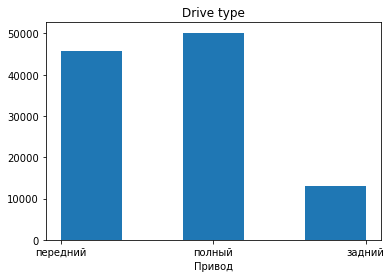

In [193]:
_ = plt.hist(df['Привод'],bins = 5)
plt.title('Drive type')
plt.xlabel('Привод')
plt.show()

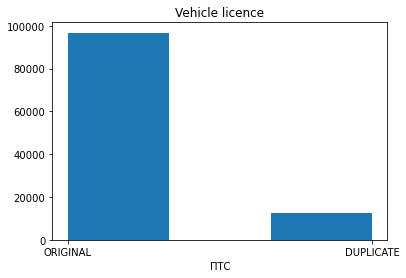

In [194]:
_ = plt.hist(df['ПТС'],bins = 3)
plt.title('Vehicle licence')
plt.xlabel('ПТС')
plt.show()

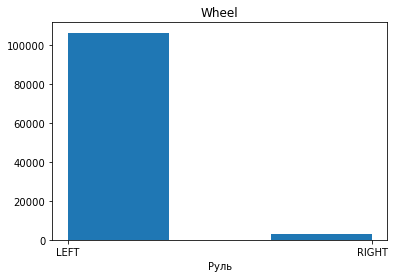

In [195]:
_ = plt.hist(df['Руль'],bins = 3)
plt.title('Wheel')
plt.xlabel('Руль')
plt.show()

Convert labels from strings to integers by LabelEncoder:

In [196]:
LABEL_ENCODERS = dict() # Encoders will be used later for transforming test dataset

In [197]:
categorical_columns = df.columns[df.dtypes == 'object']

for column in categorical_columns:
    le = preprocessing.LabelEncoder()
    df[column] = le.fit_transform(list(df[column]))
    LABEL_ENCODERS.update({column:le})

Plot correlation matrix:

In [198]:
corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "6pt")]),
            dict(selector="td",
                 props=[('padding', "0.4em 0.4em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '80px'),
                        ('font-size', '8pt'),
                        ('min-width','80px')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '12pt'})\
    .set_caption("correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Price
bodyType,1.00,0.05,0.01,-0.19,-0.21,-0.42,-0.21,-0.01,-0.17,-0.29,0.17,-0.57,0.07,0.17,-0.10,-0.22
brand,0.05,1.00,0.09,-0.04,-0.03,0.10,-0.01,0.08,-0.35,-0.34,0.03,-0.01,0.06,-0.07,0.04,-0.15
color,0.01,0.09,1.00,-0.06,0.06,0.01,0.07,0.08,-0.14,-0.15,-0.07,-0.06,0.05,-0.07,0.04,-0.06
fuelType,-0.19,-0.04,-0.06,1.00,0.12,0.14,0.13,-0.20,0.17,0.05,-0.02,0.25,-0.03,-0.09,0.06,0.23
modelDate,-0.21,-0.03,0.06,0.12,1.00,0.17,0.97,0.09,0.06,0.23,-0.68,0.23,-0.20,-0.49,0.27,0.40
numberOfDoors,-0.42,0.10,0.01,0.14,0.17,1.00,0.18,0.09,-0.05,-0.01,-0.07,0.43,-0.02,-0.16,0.11,0.02
productionDate,-0.21,-0.01,0.07,0.13,0.97,0.18,1.00,0.09,0.05,0.20,-0.70,0.23,-0.21,-0.51,0.28,0.40
vehicleConfiguration,-0.01,0.08,0.08,-0.20,0.09,0.09,0.09,1.00,-0.29,-0.29,-0.11,-0.02,0.00,-0.12,0.05,-0.15
engineDisplacement,-0.17,-0.35,-0.14,0.17,0.06,-0.05,0.05,-0.29,1.00,0.66,-0.02,0.18,-0.04,0.06,-0.04,0.33
enginePower,-0.29,-0.34,-0.15,0.05,0.23,-0.01,0.20,-0.29,0.66,1.00,-0.17,0.34,-0.10,-0.01,-0.00,0.52


We can drop one of date columns - сorelation coeficient of them is 0.97

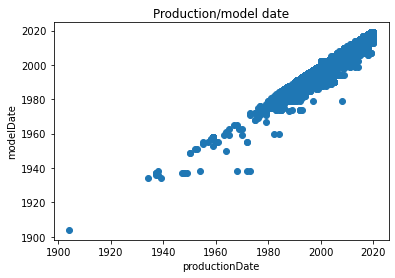

In [199]:
plt.title('Production/model date')
plt.xlabel('productionDate')
plt.ylabel('modelDate')
plt.scatter(df.productionDate,df.modelDate)

In [200]:
df.drop('modelDate',axis=1,inplace=True)

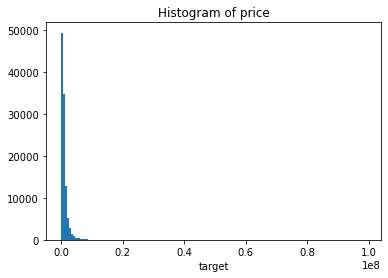

In [201]:
_ = plt.hist(df['Price'],bins = 150)
plt.title('Histogram of price')
plt.xlabel('target')
plt.show()

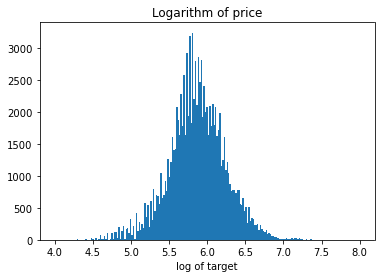

In [24]:
_ = plt.hist(np.log10(df['Price']),bins = 'auto')
plt.title('Logarithm of price')
plt.xlabel('log of target')
plt.show()

As we can see, logarithm of price has a normal distribution.

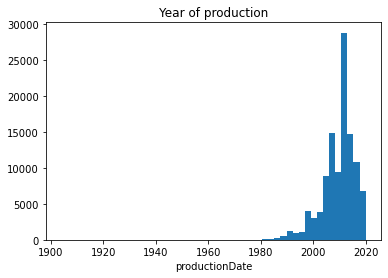

In [25]:
_ = plt.hist(df['productionDate'],bins = 50)
plt.title('Year of production')
plt.xlabel('productionDate')
plt.show()

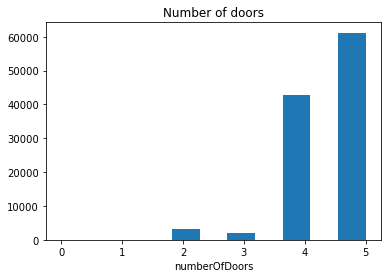

In [26]:
_ = plt.hist(df['numberOfDoors'],bins = 11)
plt.title('Number of doors')
plt.xlabel('numberOfDoors')
plt.show()

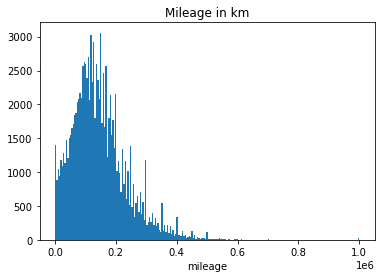

In [27]:
_ = plt.hist(df['mileage'],bins = 'auto')
plt.title('Mileage in km')
plt.xlabel('mileage')
plt.show()

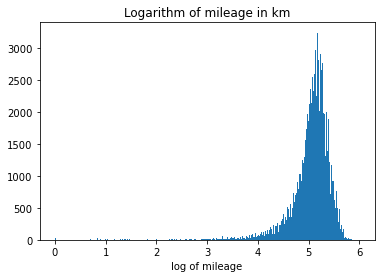

In [28]:
_ = plt.hist(np.log10(df['mileage']),bins = 'auto')
plt.title('Logarithm of mileage in km')
plt.xlabel('log of mileage')
plt.show()

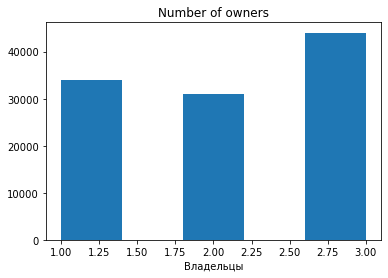

In [29]:
_ = plt.hist(df['Владельцы'],bins = 5)
plt.title('Number of owners')
plt.xlabel('Владельцы')
plt.show()

#### Scatter

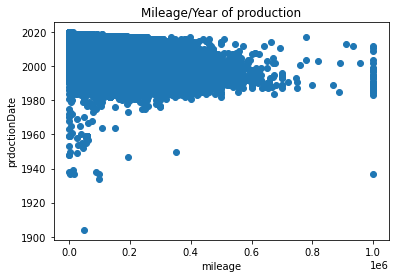

In [30]:
_ = plt.scatter(df['mileage'],df['productionDate'])

plt.title('Mileage/Year of production')
plt.xlabel('mileage')
plt.ylabel('prdoctionDate')

plt.show()

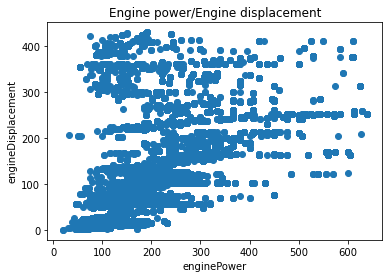

In [31]:
_ = plt.scatter(df['enginePower'],df['engineDisplacement'])

plt.title('Engine power/Engine displacement')
plt.xlabel('enginePower')
plt.ylabel('engineDisplacement')

plt.show()

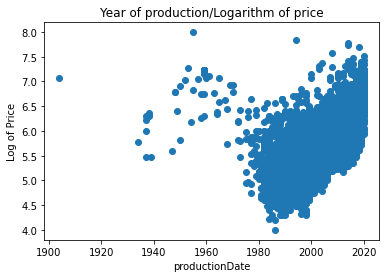

In [32]:
_ = plt.scatter(df['productionDate'],
                np.log10(df['Price']))

plt.title('Year of production/Logarithm of price')
plt.xlabel('productionDate')
plt.ylabel('Log of Price')

plt.show()

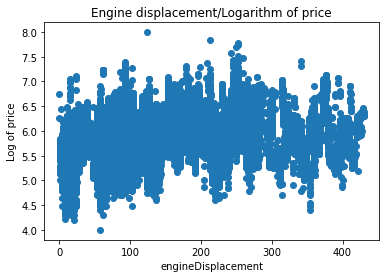

In [33]:
_ = plt.scatter(df['engineDisplacement'],
                np.log10(df['Price']))

plt.title('Engine displacement/Logarithm of price')
plt.xlabel('engineDisplacement')
plt.ylabel('Log of price')

plt.show()

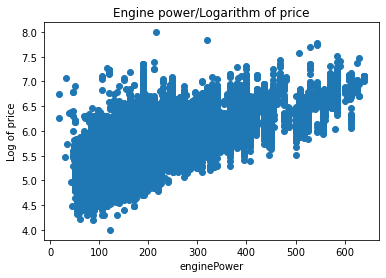

In [34]:
_ = plt.scatter(df['enginePower'],
                np.log10(df['Price']))

plt.title('Engine power/Logarithm of price')
plt.xlabel('enginePower')
plt.ylabel('Log of price')

plt.show()

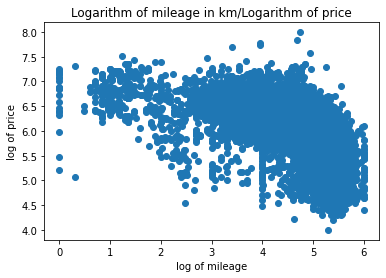

In [35]:
_ = plt.scatter(np.log10(df['mileage']),
                np.log10(df['Price']))

plt.title('Logarithm of mileage in km/Logarithm of price')
plt.xlabel('log of mileage')
plt.ylabel('log of price')

plt.show()

So, as we can see, logarithms of mileage and price have normal distribution. So, we will apply `np.log10()` to this columns

In [202]:
df['Price'] = df['Price'].apply(np.log10)
df['mileage'] = df['mileage'].apply(np.log10)

#### Baseline

In [203]:
y = df['Price']
X = df.drop('Price',axis=1)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [205]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [206]:
predict = X_test['bodyType'].map(tmp_train.groupby('bodyType')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mean_absolute_percentage_error(np.power(10,y_test), np.power(10,predict.values)))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 71.35%


## Machine Learning

In [211]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 9, 21)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 70, 90)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 loss = 'ls',
                                                 random_state = RANDOM_SEED)

    gradientboosting.fit(X_train, y_train)

    test_predict = gradientboosting.predict(X_test)

    return mean_absolute_percentage_error(np.power(10,y_test),np.power(10,test_predict))

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 30)

[I 2021-02-08 23:32:41,674] A new study created in memory with name: no-name-cf6bc9f4-c93a-43b2-a080-272ef2f10cb6
[I 2021-02-08 23:33:40,479] Trial 0 finished with value: 0.13567310988942693 and parameters: {'gb_max_depth': 19, 'gb_n_estimators': 90}. Best is trial 0 with value: 0.13567310988942693.
[I 2021-02-08 23:34:27,900] Trial 1 finished with value: 0.1290350896409346 and parameters: {'gb_max_depth': 17, 'gb_n_estimators': 78}. Best is trial 1 with value: 0.1290350896409346.
[I 2021-02-08 23:35:09,357] Trial 2 finished with value: 0.12383126696317598 and parameters: {'gb_max_depth': 12, 'gb_n_estimators': 88}. Best is trial 2 with value: 0.12383126696317598.
[I 2021-02-08 23:35:40,784] Trial 3 finished with value: 0.1302063522198425 and parameters: {'gb_max_depth': 9, 'gb_n_estimators': 84}. Best is trial 2 with value: 0.12383126696317598.
[I 2021-02-08 23:36:11,667] Trial 4 finished with value: 0.1265276577721569 and parameters: {'gb_max_depth': 11, 'gb_n_estimators': 70}. Best 

In [72]:
prediction = sklearn_model.predict(X_test)
mean_absolute_percentage_error(np.power(10,y_test),np.power(10,prediction))

0.12594225006374424

In [61]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_tray_train_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [62]:
prediction = np.power(10,model.predict(X_test))
mean_absolute_percentage_error(np.power(10,y_test),prediction)

0.1277907535412283

## Submission

In [136]:
submission= pd.read_csv('submission_data1.csv')

In [15]:
submission.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

In [137]:
submission.head(2)

,Unnamed: 0,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС
0,0,Лифтбек,SKODA,синий,бензин,2013,5,2014,ROBOT,1.2 LTR,105 N12,74000,передний,LEFT,3.0,ORIGINAL
1,1,Лифтбек,SKODA,чёрный,бензин,2017,5,2017,MECHANICAL,1.6 LTR,110 N12,60563,передний,LEFT,1.0,ORIGINAL


In [16]:
df.head(2)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Price
0,Седан,AUDI,040001,бензин,1990.0,4.0,1991,MECHANICAL,2.3,133.0,10000,передний,LEFT,3.0,ORIGINAL,135000
1,Седан,AUDI,040001,бензин,1988.0,4.0,1989,MECHANICAL,2.0,115.0,300000,передний,LEFT,3.0,DUPLICATE,42000


In [18]:
submission.drop(['vehicleConfiguration'],axis=1,inplace=True)
submission['vehicleConfiguration'] = submission['vehicleTransmission']
submission.drop(['vehicleTransmission'],axis=1,inplace=True)
submission.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,super_gen,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,vehicleConfiguration
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,"{""id"":""10373605"",""displacement"":1197,""engine_t...",EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,роботизированная
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,"{""id"":""20913311"",""displacement"":1598,""engine_t...",EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,механическая


In [19]:
submission['ПТС'].fillna('DUPLICATE',inplace=True)

In [20]:
df.drop('Price',axis=1).columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'engineDisplacement',
       'enginePower', 'mileage', 'Привод', 'Руль', 'Владельцы', 'ПТС'],
      dtype='object')

In [82]:
#submission = submission[df.drop('Price',axis=1).columns]
submission.head(2)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС
0,Лифтбек,SKODA,синий,бензин,2013,5,2014,роботизированная,1.2 LTR,105 N12,74000,передний,LEFT,3.0,Оригинал
1,Лифтбек,SKODA,чёрный,бензин,2017,5,2017,механическая,1.6 LTR,110 N12,60563,передний,LEFT,1.0,Оригинал


In [44]:
submission['bodyType'] = submission.bodyType.apply(lambda x: x.split()[0].capitalize())

In [84]:
df.drop('Price',axis=1).head(2)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС
0,Седан,AUDI,040001,бензин,1990.0,4.0,1991,MECHANICAL,2.3,133.0,10000,передний,LEFT,3.0,ORIGINAL
1,Седан,AUDI,040001,бензин,1988.0,4.0,1989,MECHANICAL,2.0,115.0,300000,передний,LEFT,3.0,DUPLICATE


In [34]:
submission['enginePower'] = submission['enginePower'].apply(lambda x: int(x.split()[0])).astype('float')

In [35]:
df.engineDisplacement.value_counts()[:100]

1.6      14236
2.0      13739
1.8       8034
1.4       4713
2.5       4676
         ...  
600        117
535i       116
325xi      114
25d        114
M50d       111
Name: engineDisplacement, Length: 100, dtype: int64

In [153]:
def func(x):
    median = 2
    x = re.sub('[^0-9\.]', '', str(x))
    try:
        x = float(x)
        if x>10:
            x=2
        return str(x)
    except ValueError:
        return median

In [63]:
submission.Привод.unique()

array(['передний', 'полный', 'задний'], dtype=object)

In [49]:
df.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [66]:
submission.Руль = submission.Руль.apply(lambda x: 'LEFT' if x=='Левый' else 'RIGHT')

In [73]:
submission.Владельцы =submission.Владельцы.apply(lambda x: float(x.split()[0]))

In [91]:
submission.ПТС.unique()

array(['Оригинал', 'Дубликат', 'DUPLICATE'], dtype=object)

In [92]:
submission.ПТС = submission.ПТС.apply(lambda x: "ORIGINAL" if x=='Оригинал' else "DUPLICATE")

In [138]:
submission.head(1)

,Unnamed: 0,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС
0,0,Лифтбек,SKODA,синий,бензин,2013,5,2014,ROBOT,1.2 LTR,105 N12,74000,передний,LEFT,3.0,ORIGINAL


In [99]:
df.head(1)

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Price
0,Седан,AUDI,040001,бензин,1990.0,4.0,1991,MECHANICAL,2.3,133.0,10000,передний,LEFT,3.0,ORIGINAL,135000


In [109]:
submission.vehicleConfiguration.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [110]:
df.vehicleConfiguration.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR'], dtype=object)

In [111]:
def conf_func(russian):
    if russian=='роботизированная':
        return 'ROBOT'
    elif russian=='механическая':
        return 'MECHANICAL'
    elif russian=='автоматическая':
        return 'AUTOMATIC'
    else:
        return 'VARIATOR'

In [133]:
submission.vehicleConfiguration = submission1.vehicleTransmission.apply(conf_func)

In [135]:
submission.to_csv("submission_data1.csv")

In [134]:
submission.vehicleConfiguration.value_counts()

AUTOMATIC     19596
MECHANICAL     7209
VARIATOR       3999
ROBOT          3882
Name: vehicleConfiguration, dtype: int64

In [147]:
df.engineDisplacement.value_counts()[:10]

1.6     14236
2.0     13739
1.8      8034
1.4      4713
2.5      4676
2.4      4056
350      3182
200      2771
3.5      2620
3.0d     2584
Name: engineDisplacement, dtype: int64

In [155]:
submission.engineDisplacement = submission.engineDisplacement.apply(func)

In [162]:
submission.enginePower = submission.enginePower.apply(func1)

In [160]:
def func1(x):
    x = re.sub('N12', '', str(x))
    return float(x)

In [165]:
submission.to_csv("submission_data2.csv")

In [239]:
df.color.value_counts()

040001    35229
FAFBFB    19636
CACECB    12700
97948F    12622
0000CC     9858
200204     5524
EE1D19     4372
007F00     2413
C49648     2124
22A0F8     1243
660099      861
DEA522      833
4A2197      673
FFD600      542
FF8649      425
FFC0CB       15
Name: color, dtype: int64

In [238]:
submission.color.value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

In [244]:
colors_codes={
    'чёрный':'040001',
    'белый':'FAFBFB',
    'серебристый':'CACECB',
    'серый':'97948F',
    'синий':'0000CC',
    'красный':'EE1D19',
    'коричневый':'200204',
    'зелёный':'007F00',
    'бежевый':'C49648',
    'голубой':'22A0F8',
    'золотистый':'DEA522',
    'пурпурный':'4A2197',
    'фиолетовый':'660099',
    'жёлтый':'FFD600',
    'оранжевый':'FF8649',
    'розовый':'FF8649'    
}


In [246]:
submission['color']=submission['color'].apply(lambda x: colors_codes[x])

In [23]:
submission.drop('Unnamed: 0',axis=1,inplace=True)

In [30]:
submission.to_csv('prepared_submission_data.csv')

In [28]:
df.dtypes

bodyType                 object
brand                    object
color                    object
fuelType                 object
modelDate               float64
numberOfDoors           float64
productionDate            int64
vehicleConfiguration     object
engineDisplacement       object
enginePower             float64
mileage                   int64
Привод                   object
Руль                     object
Владельцы               float64
ПТС                      object
Price                     int64
dtype: object

In [31]:
submission = pd.read_csv('prepared_submission_data.csv')

In [29]:
submission.drop('Unnamed: 0',axis=1).dtypes

bodyType                 object
brand                    object
color                    object
fuelType                 object
modelDate                 int64
numberOfDoors             int64
productionDate            int64
vehicleConfiguration     object
engineDisplacement       object
enginePower             float64
mileage                   int64
Привод                   object
Руль                     object
Владельцы               float64
ПТС                      object
dtype: object

In [27]:
submission['engineDisplacement'] = submission.engineDisplacement.astype('object')